In [1]:
import sys
sys.path.append("../") # go to parent dir

In [2]:
FILENAME="td_percentage_definition"
GIT_USER_NAME="SEI-DO3SE"
GIT_REPO_NAME="do3se_phenology"
DEPENDENCIES=[
    ("thermal_time", "github.com/SEI-DO3SE/thermal_time.git"),
    ("do3se_phenology", "github.com/SEI-DO3SE/do3se_phenology.git"),
    ("do3se_met", "github.com/SEI-DO3SE/do3se_met.git"),
    ("notebook_utils", "github.com/sbland/notebook_utils.git"),
]

In [3]:
# Add colab link
from IPython.display import Markdown as md
md(f"""
<a href="https://colab.research.google.com/github/{GIT_USER_NAME}/{GIT_REPO_NAME}/blob/master/notebooks/{FILENAME}.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>
""")


<a href="https://colab.research.google.com/github/SEI-DO3SE/do3se_phenology/blob/master/notebooks/td_percentage_definition.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>


In [4]:
# Colab setup
#@title Download libraries from github
#@markdown Code Hidden
try:
    import importlib
    for name, path in DEPENDENCIES:
        importlib.import_module(name)
except (ImportError, ModuleNotFoundError):
    if 'google.colab' in str(get_ipython()):
        print('Running on CoLab')
        print("""
        This notebook requires access to private repositories. To access follow the steps below:
        1. Get an access key from your github account: https://docs.github.com/en/github/authenticating-to-github/creating-a-personal-access-token
        2. Save the key to a file in the following location on your google drive: `My Drive/access/collabaccess.txt`. The file should include your user on the first line and your token on the second.
        """)
        from google.colab import drive
        drive.mount('/content/drive')

        !mkdir -p ~/.access
        !cp "/content/drive/My Drive/access/collabaccess.txt" ~/.access/config
        import os
        creds = open(f'{os.path.expanduser("~")}/.access/config')
        creds_parsed = creds.read().splitlines()
        user, token = creds_parsed
        for name, path in DEPENDENCIES:
            !pip install git+https://{user}:{token}@{path}
        creds.close()
        creds = None
        creds_parsed = None

In [5]:
import pandas as pd
from matplotlib import pyplot as plt
from collections import namedtuple
from dataclasses import dataclass
from typing import List
from itertools import accumulate
import numpy as np
from functools import partial
from notebook_utils.widgets import *

In [6]:
from do3se_met.irradiance import *
from thermal_time.calcs import *

In [7]:
%load_ext autoreload
%autoreload 2

from do3se_phenology.phyllochron_dvi import *
from do3se_phenology.td_percent_definition import *
from do3se_phenology.f_phen import *
from do3se_phenology.plots import *


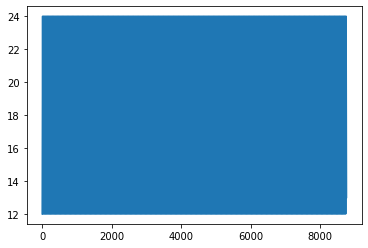

In [8]:
# Demo data
day_count = 365
lat = 20

dd_data = np.array([[d for i in range(24)] for d in range(day_count)]).reshape(day_count * 24)
hrs_data = np.array([[i for i in range(24)] for d in range(day_count)]).reshape(day_count * 24)
demo_temp_data = [24-abs(hr-12) for hr in hrs_data]
accumulated_temperatures = list(accumulate(demo_temp_data))

plt.plot(demo_temp_data)
 


In [9]:
# Calc thermal time and photoperiod
T_b, T_o, T_m = [0,20,50]
lat = 50
p_crit=24
p_sens=0
tsc = demo_temp_data
td = calc_thermal_time_range(tsc, t_b=T_b)
teff = [calc_effective_temperature(sum(tsc[d*24:(d+1)*24]),T_b, T_o, T_m) for d in dd_data]
photoperiod = [calc_photoperiod(dd, lat) for dd in dd_data]
rpe = [calc_rpe(p_crit=p_crit, p_sens=p_sens, p=P) for P in photoperiod]

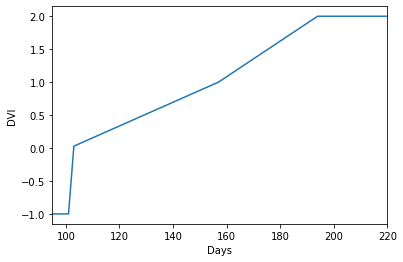

In [10]:
# Calc DVI

dvi = [-1]
tt_emr, tt_veg, tt_rep = [35, 1000, 666]
sowing_day = 100
for t, rp, d, hr in zip(teff, rpe, dd_data, hrs_data):
  if hr == 0:
    new_dvi = calc_dvi(dvi[-1],t, tt_emr, tt_veg, tt_rep, rp,d, sowing_day)
    dvi.append(new_dvi)
plt.xlim(sowing_day - 5, sowing_day+120)
plt.plot(dvi)
plt.xlabel("Days")
plt.ylabel("DVI")
plt.show()

In [11]:
emergence_day = next(dz for dz, dv in enumerate(dvi) if dv > 0)
phyllochron = calc_phyllochron(photoperiod[emergence_day] - photoperiod[emergence_day-1])


# Interactive

## DVI

In [12]:
#@title Life stage from td_data
@interact_plus_reset(
  tt_emr = widgets.FloatSlider(min=1, max=2000, value=35, step=1), 
  tt_veg = widgets.FloatSlider(min=1, max=2000, value=1000, step=1), 
  tt_rep = widgets.FloatSlider(min=1, max=2000, value=666, step=1), 
  sowing_day = widgets.FloatSlider(min=1, max=365, value=100, step=1),   
)
def run(tt_emr, tt_veg, tt_rep, sowing_day):
  dvi = [-1]
  for t, rp, d, hr in zip(teff, rpe, dd_data, hrs_data):
    if hr == 0:
      new_dvi = calc_dvi(dvi[-1],t, tt_emr, tt_veg, tt_rep, rp,d, sowing_day)
      dvi.append(new_dvi)
  plt.xlim(sowing_day - 5, sowing_day+120)
  plt.plot(dvi)
  plt.xlabel("Days")
  plt.ylabel("DVI")

  emergence_day = next(dz for dz, dv in enumerate(dvi) if dv > 0)
  phyllochron = calc_phyllochron(photoperiod[emergence_day] - photoperiod[emergence_day-1])
  life_stages = calc_life_stages_from_phyllochron(phyllochron, t_lse_constant=0.3)
  life_stages
  plt.show()


Button(description='Reset', style=ButtonStyle())

Output()

## Get thermal days


In [13]:
    (
        SGS,
        EGS,
        Astart,
        mid_anthesis,
        fphen_a,
        fphen_b,
        fphen_c,
        fphen_d,
        dd_emr,
        dd_veg,
        dd_rep,
        t_Astart,
        t_mid_anthesis,
        t_fphen_a,
        t_fphen_b,
        t_fphen_c,
        t_fphen_d,
        tt_emr,
        tt_veg,
        tt_rep,
    ) = get_canopy_td_intervals(
        td,
        dd_data,
        t_sgs=100,
        t_egs=1850,
    )

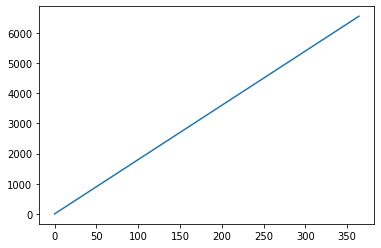

In [14]:
td_daily = [td for td, hr in zip(td, hrs_data) if hr == 0]
plt.plot(td_daily)

In [15]:
#@title leaf_f_phen
@interact_plus_reset(
  tt_emr = widgets.FloatSlider(min=1, max=2000, value=35, step=1), 
  tt_veg = widgets.FloatSlider(min=1, max=2000, value=1000, step=1), 
  tt_rep = widgets.FloatSlider(min=1, max=2000, value=666, step=1), 
  t_astart=widgets.FloatSlider(min=1, max=2000, value=950, step=1),
  td_at_sgs=widgets.FloatSlider(min=1, max=2000, value=100, step=1),
)
def get_t_l(
    tt_emr, tt_veg, tt_rep,
    t_astart,
    td_at_sgs,
):
    # DVI
    fig, axs = plt.subplots(ncols=2)
    dvi = [-1]
    for t, rp, d, hr in zip(teff, rpe, dd_data, hrs_data):
        if hr == 0:
            new_dvi = calc_dvi(dvi[-1],t, tt_emr, tt_veg, tt_rep, rp,d, sowing_day)
            dvi.append(new_dvi)
    

    axs[0].plot(td_daily, dvi[1:])
    axs[0].set_xlabel("Days")
    axs[0].set_ylabel("DVI")
    emergence_day = next(dz for dz, dv in enumerate(dvi) if dv > 0)
    phyllochron = calc_phyllochron(photoperiod[emergence_day] - photoperiod[emergence_day-1])

    # t_l
    t_lse_constant=0.3
    LS = calc_life_stages_from_phyllochron(phyllochron, t_lse_constant=t_lse_constant)
    td_dd_list = [t - t_astart - td_at_sgs for t in td]
    f_LA = [max(0,min(1,1 - (td_dd - LS.t_lem) / (LS.t_lma))) for td_dd in td_dd_list]
    fO3_l = 1
    f_LS = [max(0,min(1,1 - ((td_dd - LS.t_lem - LS.t_lep) / (LS.t_lma / fO3_l - LS.t_lep)))) for td_dd in td_dd_list]

    axs[1].plot(td, f_LA, label="f_LA")
    axs[1].plot(td, f_LS, label="f_LS")
    axs[1].axvline(td_at_sgs + t_astart + LS.t_l, linestyle='dotted', color="red")
    axs[1].text(td_at_sgs + t_astart + LS.t_l, 0.5, 't_l', rotation=45, color="red")
    axs[1].axvline(td_at_sgs + t_astart, linestyle='dotted', color="green")
    axs[1].text(td_at_sgs + t_astart, 0.5, 't_Astart', rotation=45, color="green")

    plt.legend()

    # DVI
    plt.show()

Button(description='Reset', style=ButtonStyle())

Output()

# Plot all

In [16]:
def calc_dvi_range(tt_emr, tt_veg, tt_rep, sowing_day):
    dvi = [-1]
    for t, rp, d, hr in zip(teff, rpe, dd_data, hrs_data):
        if hr == 0:
            new_dvi = calc_dvi(dvi[-1],t, tt_emr, tt_veg, tt_rep, rp,d, sowing_day)
            dvi.append(new_dvi)
    return dvi


In [17]:
#@title leaf_f_phen
td_daily = [td for td, hr in zip(td, hrs_data) if hr == 0]

@interact_plus_reset(
  t_sgs = widgets.FloatSlider(min=1, max=2000, value=200, step=1), 
  t_egs = widgets.FloatSlider(min=1, max=6000, value=1995, step=1),
#   tt_emr = widgets.FloatSlider(min=1, max=2000, value=35, step=1), 
#   tt_veg = widgets.FloatSlider(min=1, max=2000, value=1000, step=1), 
#   tt_rep = widgets.FloatSlider(min=1, max=2000, value=666, step=1), 
)
def get_t_l(
    t_sgs,t_egs,
    # tt_emr, tt_veg, tt_rep,
):
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16, 10))
    (
        SGS,
        EGS,
        Astart,
        mid_anthesis,
        fphen_a,
        fphen_b,
        fphen_c,
        fphen_d,
        dd_emr,
        dd_veg,
        dd_rep,
        t_Astart,
        t_mid_anthesis,
        t_f_phen_a,
        t_f_phen_b,
        t_f_phen_c,
        t_f_phen_d,
        tt_emr,
        tt_veg,
        tt_rep,
    ) = get_canopy_td_intervals(
        td,
        dd_data,
        t_sgs=t_sgs,
        t_egs=t_egs,
    )

    f_phen_data = tt_f_phen_simple_PLF_range(
        td,
        t_f_phen_a,
        t_f_phen_b,
        t_f_phen_c,
        t_f_phen_d,
        f_phen_min=0.2,
        td_at_sgs=t_sgs,
    )

    (
        SGS,
        EGS,
        Astart,
        mid_anthesis,
        fphen_1_ets,
        fphen_3_ets,
        fphen_4_ets,
        fphen_5_ets,
        t_Astart,
        t_mid_anthesis,
        t_fphen_1_ets,
        t_fphen_3_ets,
        t_fphen_4_ets,
        t_fphen_5_ets,
        t_lem,
        t_lse,
        t_lma,
        t_lep,
        lem,
        lse,
        lma,
        lep,
    ) = get_leaf_td_intervals(
        td,
        dd_data,
        t_sgs=t_sgs,
        t_egs=t_egs,
    )

    t_leaf_f_phen_a = 0.3
    t_leaf_f_phen_b = 0.7
    t_leaf_f_phen_e = t_fphen_1_ets
    t_leaf_f_phen_g = t_fphen_3_ets
    t_leaf_f_phen_h = t_fphen_4_ets
    t_leaf_f_phen_i = t_fphen_5_ets
    t_astart = t_Astart
    td_at_sgs = t_sgs

    leaf_f_phen_data = tt_leaf_f_phen_PLF_range(
        td,
        t_leaf_f_phen_a,
        t_leaf_f_phen_b,
        t_leaf_f_phen_e,
        t_leaf_f_phen_g,
        t_leaf_f_phen_h,
        t_leaf_f_phen_i,
        t_astart,
        td_at_sgs,
    )

    # ===== PLOTS ===== #
    # Leaf f phen
    # Plot thermal time
    plot_leaf_f_phen_data(
        td,
        leaf_f_phen_data,
        t_leaf_f_phen_a,
        t_leaf_f_phen_b,
        t_leaf_f_phen_e,
        t_leaf_f_phen_g,
        t_leaf_f_phen_h,
        t_leaf_f_phen_i,
        t_astart,
        t_sgs,
        t_egs,
        ax=axs[0][0],
        ax_box=axs[1][0],
    )

    # Plot days
    plot_leaf_f_phen_data(
        dd_data,
        leaf_f_phen_data,
        t_leaf_f_phen_a,
        t_leaf_f_phen_b,
        fphen_1_ets,
        fphen_3_ets,
        fphen_4_ets,
        fphen_5_ets,
        Astart,
        SGS,
        EGS,
        ax=axs[0][1],
        ax_box=axs[1][1],
    )

    # f phen
    plot_f_phen_data(
        td,
        f_phen_data,
        t_sgs,
        t_egs,
        t_f_phen_a,
        t_f_phen_b,
        t_f_phen_c,
        t_f_phen_d,
        ax=axs[0][0],
        ax_box=axs[1][0],
        box_y_start=10,
    )

    plot_f_phen_data(
        dd_data,
        f_phen_data,
        SGS,
        EGS,
        fphen_a - SGS,
        fphen_b - SGS,
        fphen_c - SGS,
        fphen_d - SGS,
        ax=axs[0][1],
        ax_box=axs[1][1],
        box_y_start=10,
    )

    # Plot fla fls
    td_dd_list = [t - t_sgs for t in td]
    f_LA = [max(0, min(1, 1 - (td_dd - t_astart) / (t_lma))) for td_dd in td_dd_list]
    # f_LA = [max(0,min(1,1 - (td_dd - t_lem) / (t_lma))) for td_dd in td_dd_list]
    fO3_l = 1
    f_LS = [max(0, min(1, 1 - ((td_dd - t_astart - t_lep) / (t_lma / fO3_l - t_lep))))
            for td_dd in td_dd_list]
    # f_LS = [max(0,min(1,1 - ((td_dd - t_lem - t_lep) / (t_lma / fO3_l - t_lep)))) for td_dd in td_dd_list]
    t_l = t_lma + t_lem

    plot_ewert_phenology_data(
        td,
        f_LA,
        f_LS,
        t_lem,
        t_lma,
        t_lep,
        t_lse,
        t_sgs,
        t_egs,
        t_Astart,
        ax=axs[0][0],
        ax_box=axs[1][0],
        box_y_start=17,
    )
    plot_ewert_phenology_data(
        dd_data,
        f_LA,
        f_LS,
        lem,
        lma,
        lep,
        lse,
        SGS,
        EGS,
        Astart,
        ax=axs[0][1],
        ax_box=axs[1][1],
        box_y_start=17,
    )

    dvi_x = [td_at_sgs, td_at_sgs + tt_emr, td_at_sgs +
             tt_emr + tt_veg, td_at_sgs + tt_emr + tt_veg + tt_rep]
    dvi_y = [-1, 0, 1, 2]

    axs[0][0].plot(dvi_x, dvi_y, label="DVI", color="yellow")

    # Setup axes
    axs[0][0].set_xlim((t_sgs - 100, t_egs + 300))
    axs[1][0].set_xlim((t_sgs - 100, t_egs + 300))
    axs[0][0].set_xlabel("thermal time")
    axs[0][0].set_ylabel("leaf_f_phen")
    axs[0][0].legend()

    axs[0][1].set_xlim(((SGS - 10), (EGS + 10)))
    axs[1][1].set_xlim(((SGS - 10), (EGS + 10)))

    axs[0][1].set_xlabel("days")
    axs[0][1].set_ylabel("leaf_f_phen")
    axs[0][1].legend()
    # plt.show()

Button(description='Reset', style=ButtonStyle())

Output()